### All images are splitted into training/test test already. Each image set has its corresponding mask images.




In [ ]:
!pip install --upgrade gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import imgaug.augmenters as iaa
import imgaug as ia
from tensorflow.keras import *
import tensorflow.keras.backend as K

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split


#### Data analysis

In [ ]:
# read img and mask
mask_paths = glob('/content/drive/MyDrive/CTScan/train_set/*_mask.jpg')
mask_path = np.random.choice(mask_paths, size=1)[0]
img_path = mask_path.replace('_mask', '')

print('img_path: ', img_path)
print('mask path:',  mask_path)

img = cv2.imread(img_path)
mask = cv2.imread(mask_path)

img_path:  /content/drive/MyDrive/CTScan/train_set/ID_d29f7d627.jpg
mask path: /content/drive/MyDrive/CTScan/train_set/ID_d29f7d627_mask.jpg


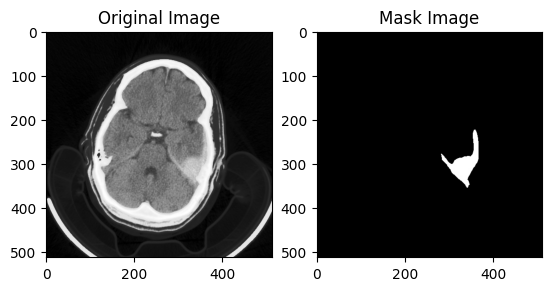

In [ ]:
# show image
# plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original Image')

# show mask
plt.subplot(1,2,2)
plt.imshow(mask)
plt.title('Mask Image')

plt.show()

#### Data Augmentation

In [ ]:
IMG_SIZE = 256 # 16x, 32x
BS = 32

In [ ]:
class DataGenerator(utils.Sequence):
    def __init__(self, folder_path, batch_size, img_size, shuffle=True, aug=False):
        self.folder_path = folder_path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.img_size = img_size
        self.aug = aug
        self.seq = iaa.Sequential([
            iaa.Fliplr(0.5), # 50% horizontal flip
            iaa.Affine(
                rotate=(-45, 45), # random rotate -45 ~ +45 degree
                shear=(-10, 10), # random shear degree
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)} # scale x, y: 80%~120%
            ),
        ])

        self.mask_paths = glob(os.path.join(folder_path, '*_mask.jpg'))
        self.img_paths = [p.replace('_mask', '') for p in self.mask_paths]
        self.indexes = np.arange(len(self.mask_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.mask_paths) / self.batch_size)) # batches per epoch

    def __getitem__(self, index):
        # Generate indexes of the batch
        idxs = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Find list of IDs
        batch_img_paths = [self.img_paths[i] for i in idxs]
        batch_mask_paths = [self.mask_paths[i] for i in idxs]

        # Generate data
        X, y = self.__data_generation(batch_img_paths, batch_mask_paths)
        return X, y

    def on_epoch_end(self):
        # Updates indexes after each epoch
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, img_paths, mask_paths):
        # Generates data containing batch_size samples
        x = np.empty((len(img_paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.empty((len(img_paths), self.img_size, self.img_size, 1), dtype=np.float32)

        for i, (img_path, mask_path) in enumerate(zip(img_paths, mask_paths)):
            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path)
            # img and mask preprocess
            img = self.preprocess(img) # 0~255 -> 0~1
            mask = self.preprocess(mask) # 0, 255 -> 0 or 1
            x[i] = img
            y[i] = mask[:,:, :1] # 3 channels -> 1 channels
        if self.aug:
            x, y = self.seq(images=x, heatmaps=y)
        return x, y
    def preprocess(self, img):
        data = cv2.resize(img, (self.img_size, self.img_size))
        data = data / 255. # normalize to 0~1
        return data

In [ ]:
train_gen = DataGenerator('/content/drive/MyDrive/CTScan/train_set', BS, IMG_SIZE, aug=True)
test_gen = DataGenerator('/content/drive/MyDrive/CTScan/test_set', BS, IMG_SIZE, aug=False)

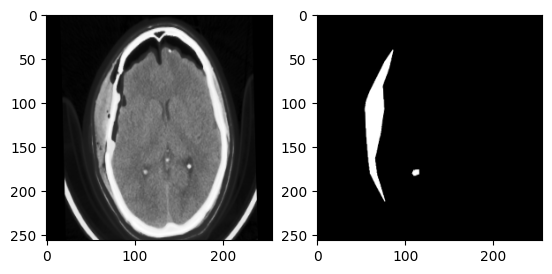

In [ ]:
# Check training output
batch_x, batch_y = train_gen[3]

for batch_i in range(1):
    # plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(batch_x[batch_i, :, :, :], cmap='gray')

    plt.subplot(1, 2, 2)
    plt.imshow(batch_y[batch_i, :, :, 0], cmap='gray')

    plt.show()


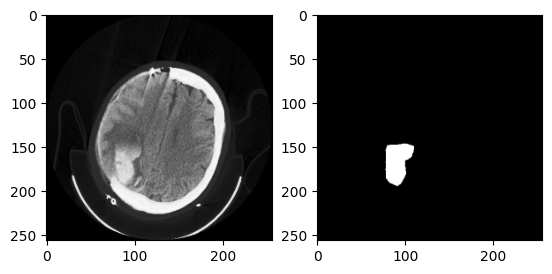

In [ ]:
# Check test output
batch_x, batch_y = test_gen[3]

for batch_i in range(1):
    # plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(batch_x[batch_i, :, :, :], cmap='gray')

    plt.subplot(1, 2, 2)
    plt.imshow(batch_y[batch_i, :, :, 0], cmap='gray')

    plt.show()

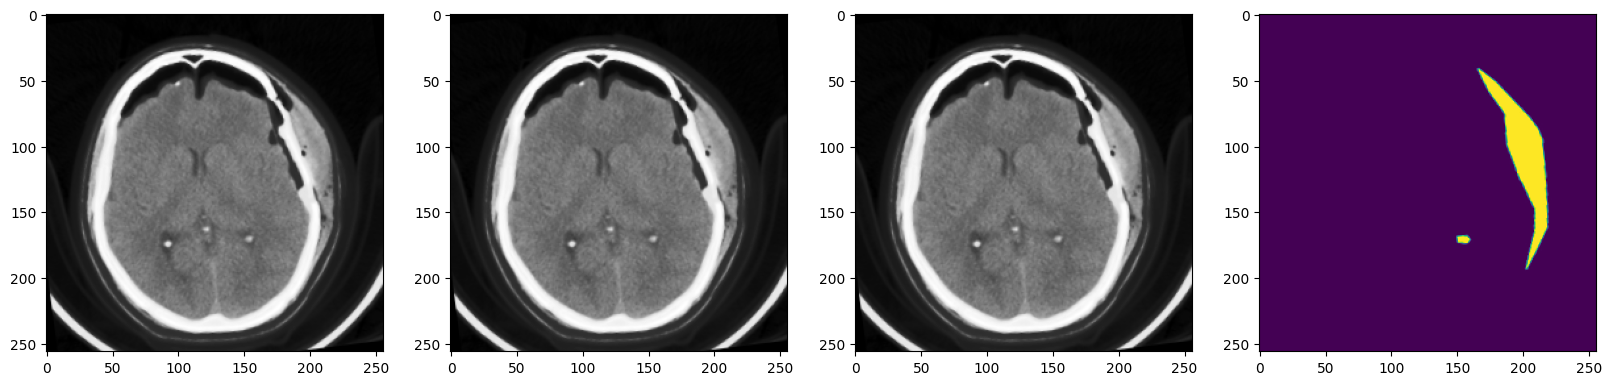

In [ ]:
# Check training output

batch_x, batch_y = train_gen[3]

for batch_i in range(1):
    plt.figure(figsize=(20, 5))
    for i in range(3):
        plt.subplot(1,4,i+1)
        plt.imshow(batch_x[batch_i, :,:,i], cmap='gray')
    plt.subplot(1, 4, 4)
    plt.imshow(batch_y[batch_i, :,:, 0])
    plt.show()

#### Build model Unet

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Clean Keras session
keras.backend.clear_session()

# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
IMG_SIZE = 256

# Method 1: Enlarge feature maps by UpSampling2D
input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Encoder
c1 = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = layers.MaxPool2D()(c1)
c2 = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = layers.MaxPool2D()(c2)
c3 = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = layers.MaxPool2D()(c3)
c4 = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)

# Decoder
l = layers.concatenate([layers.UpSampling2D()(c4),
                        c3], axis=-1)
l = layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = layers.concatenate([layers.UpSampling2D()(l),
                        c2], axis=-1)
l = layers.Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = layers.concatenate([layers.UpSampling2D()(l),
                        c1], axis=-1)
l = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(l)
l = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(l)

# Output
output_layer = layers.Conv2D(filters=1,
                             kernel_size=1,
                             activation='sigmoid')(l)

model = models.Model(input_layer, output_layer)

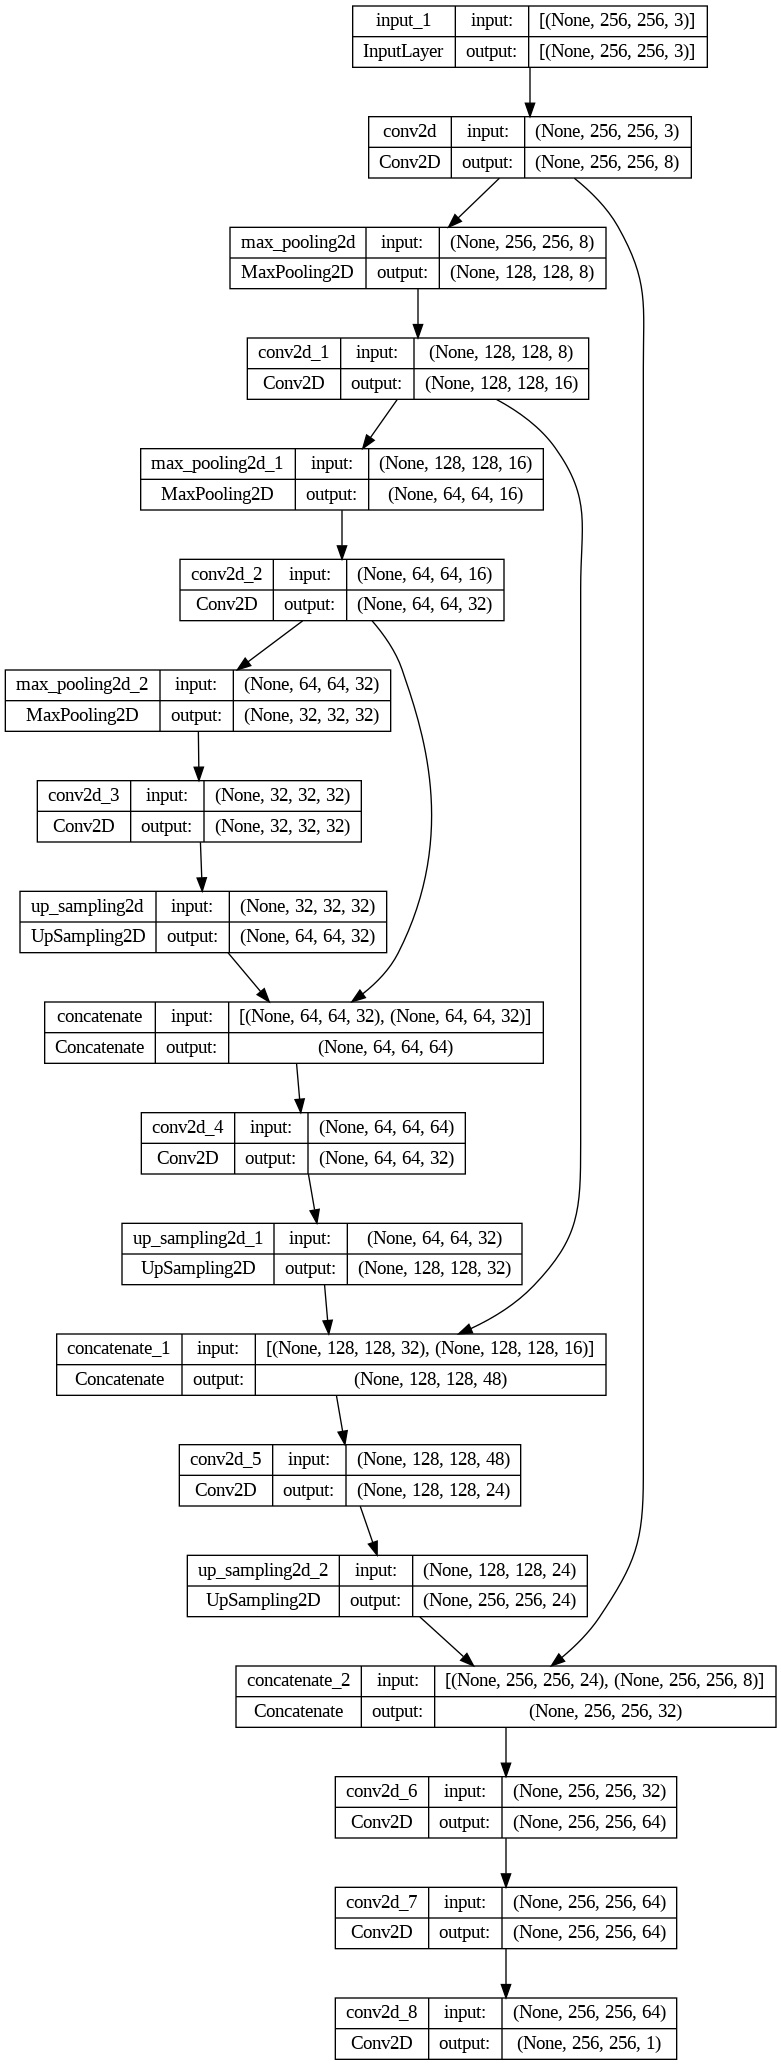

In [ ]:
utils.plot_model(model, show_shapes=True)

#### Training

In [ ]:
# Customize Metrics: Dice coefficient
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

# Customize Dice Loss
def dice_loss(y_true, y_pred):
    dice = dice_coef(y_true, y_pred)
    return 1 - dice

In [ ]:
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy', # keras.losses.BinaryCrossentropy()
            #   loss=dice_loss,
              metrics=[dice_coef])

In [ ]:
weight_saver = callbacks.ModelCheckpoint('/content/drive/MyDrive/CTScan/unet_seg_20231218.h5',
                                         save_best_only=True)
earlystop = callbacks.EarlyStopping(monitor='val_loss',
                                    patience=5)

In [ ]:
logs = model.fit(train_gen,
                 validation_data = test_gen,
                 epochs=100,
                 callbacks = [weight_saver, earlystop])



Epoch 1/100
111/111 [==============================] - 1792s 16s/step - loss: 0.0768 - dice_coef: 0.0241 - val_loss: 0.0306 - val_dice_coef: 0.0374


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
111/111 [==============================] - 76s 690ms/step - loss: 0.0294 - dice_coef: 0.0454 - val_loss: 0.0264 - val_dice_coef: 0.0788
Epoch 3/100
111/111 [==============================] - 64s 579ms/step - loss: 0.0259 - dice_coef: 0.1061 - val_loss: 0.0237 - val_dice_coef: 0.1564
Epoch 4/100
111/111 [==============================] - 64s 577ms/step - loss: 0.0240 - dice_coef: 0.1689 - val_loss: 0.0236 - val_dice_coef: 0.1599
Epoch 5/100
111/111 [==============================] - 67s 606ms/step - loss: 0.0224 - dice_coef: 0.2190 - val_loss: 0.0225 - val_dice_coef: 0.2134
Epoch 6/100
111/111 [==============================] - 63s 571ms/step - loss: 0.0228 - dice_coef: 0.2238 - val_loss: 0.0231 - val_dice_coef: 0.2234
Epoch 7/100
111/111 [==============================] - 62s 561ms/step - loss: 0.0221 - dice_coef: 0.2485 - val_loss: 0.0214 - val_dice_coef: 0.2431
Epoch 8/100
111/111 [==============================] - 63s 564ms/step - loss: 0.0214 - dice_coef: 0.2674 - val_l

#### Evaluate

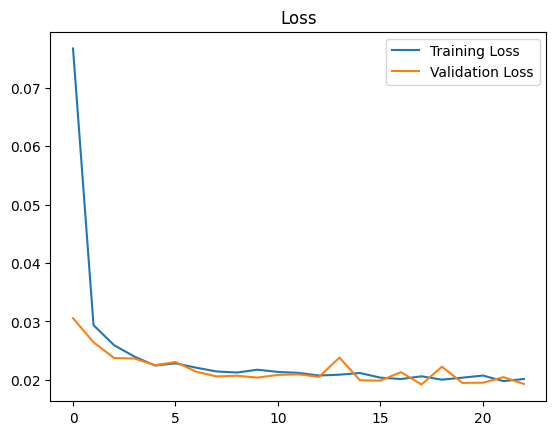

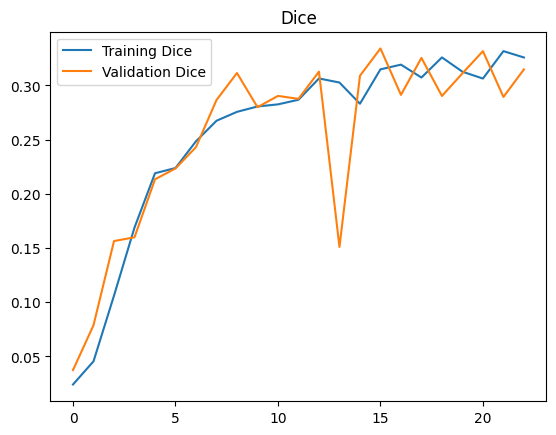

In [ ]:
# Assuming history is a dictionary with keys 'loss', 'val_loss', 'dice_coef', 'val_dice_coef'
history = logs.history

# Plot the loss curve
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()  # Add legend to the plot
plt.savefig('/content/drive/MyDrive/CTScan/loss_plot_20231218.png')
plt.show()

# Plot the Dice curve
plt.plot(history['dice_coef'], label='Training Dice')
plt.plot(history['val_dice_coef'], label='Validation Dice')
plt.title('Dice')
plt.legend()  # Add legend to the plot
plt.savefig('/content/drive/MyDrive/CTScan/dice_plot_20231218.png')
plt.show()

In [ ]:
model_final = models.load_model('/content/drive/MyDrive/CTScan/unet_seg_20231218.h5', compile=False)

In [ ]:
# Sample 1 batch
batch_idx = np.random.randint(len(test_gen))
print(batch_idx)
data = test_gen[batch_idx]
imgs, mask = data # (bs, 256, 256, 3), (bs, 256, 256, 1)
mask_pred = model_final.predict(imgs)

29
1/1 [==============================] - 0s 36ms/step


In [ ]:
# Assuming you have functions dice_coef and dice_loss defined

# Calculate Dice coefficient and Dice loss
dice_coefficient = dice_coef(mask, mask_pred)
dice_loss_value = dice_loss(mask, mask_pred)

# Print the results
print(f'Dice Coefficient on Test Set: {dice_coefficient:.4f}')
print(f'Dice Loss on Test Set: {dice_loss_value:.4f}')

Dice Coefficient on Test Set: 0.3578
Dice Loss on Test Set: 0.6422


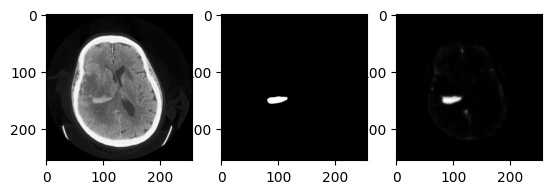

In [ ]:
# show inputs
img_idx = np.random.randint(len(imgs)) # sample 1 image from batch
# plt.figure(figsize=(20, 5))

plt.subplot(1,3, 1)
plt.imshow(imgs[img_idx, :,:, :], cmap='gray')


# show ground truth & model prediction
# plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 2)
plt.imshow(mask[img_idx, :, :, 0], cmap= 'gray')
plt.subplot(1, 3, 3)
plt.imshow(mask_pred[img_idx, :, :, 0], cmap = 'gray')

output_file_path = '/content/drive/MyDrive/CTScan/output_prediction20231218_image36.jpg'
plt.savefig(output_file_path, format='jpeg', dpi=300)  # You can adjust the DPI as needed

plt.show()
# plt.imshow(mask_pred[img_idx, :, :, 0], cmap='gray')

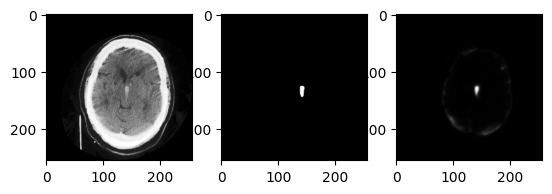

In [ ]:
# show inputs
img_idx = np.random.randint(len(imgs)) # sample 1 image from batch
# plt.figure(figsize=(20, 5))

plt.subplot(1,3, 1)
plt.imshow(imgs[img_idx, :,:, :], cmap='gray')


# show ground truth & model prediction
# plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 2)
plt.imshow(mask[img_idx, :, :, 0], cmap= 'gray')
plt.subplot(1, 3, 3)
plt.imshow(mask_pred[img_idx, :, :, 0], cmap = 'gray')

output_file_path = '/content/drive/MyDrive/CTScan/output_prediction20231218_image37.jpg'
plt.savefig(output_file_path, format='jpeg', dpi=300)  # You can adjust the DPI as needed

plt.show()
# plt.imshow(mask_pred[img_idx, :, :, 0], cmap='gray')

In [ ]:
# Displayed by different threshold
mask_pred_raw = mask_pred[img_idx, :, :, 0]
mask_pred_raw

array([[8.95388512e-05, 4.73721897e-08, 3.01156544e-09, ...,
        7.08287189e-08, 7.77894400e-07, 5.43075366e-05],
       [9.89260318e-09, 7.41927763e-15, 4.26745787e-17, ...,
        1.87272801e-14, 1.97117236e-12, 9.75881331e-09],
       [2.63612382e-10, 1.60295741e-17, 4.17886540e-20, ...,
        3.49482915e-17, 8.62804362e-15, 2.81634827e-10],
       ...,
       [6.11372997e-08, 2.15524687e-13, 2.14875551e-15, ...,
        1.33673740e-11, 6.73545553e-10, 6.96281404e-07],
       [1.30916135e-06, 4.92614595e-11, 1.07193475e-12, ...,
        1.65881708e-09, 4.38809344e-08, 1.21767325e-05],
       [1.22599973e-04, 1.57376419e-07, 1.29461419e-08, ...,
        1.69259886e-06, 1.52781977e-05, 6.69190718e-04]], dtype=float32)

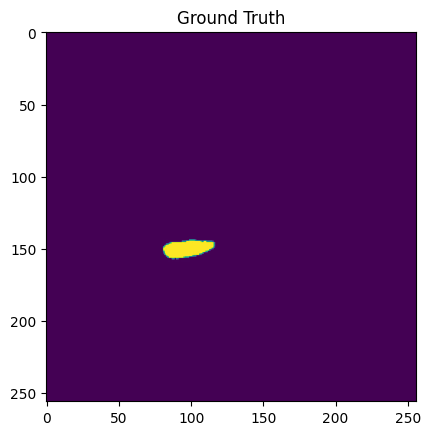

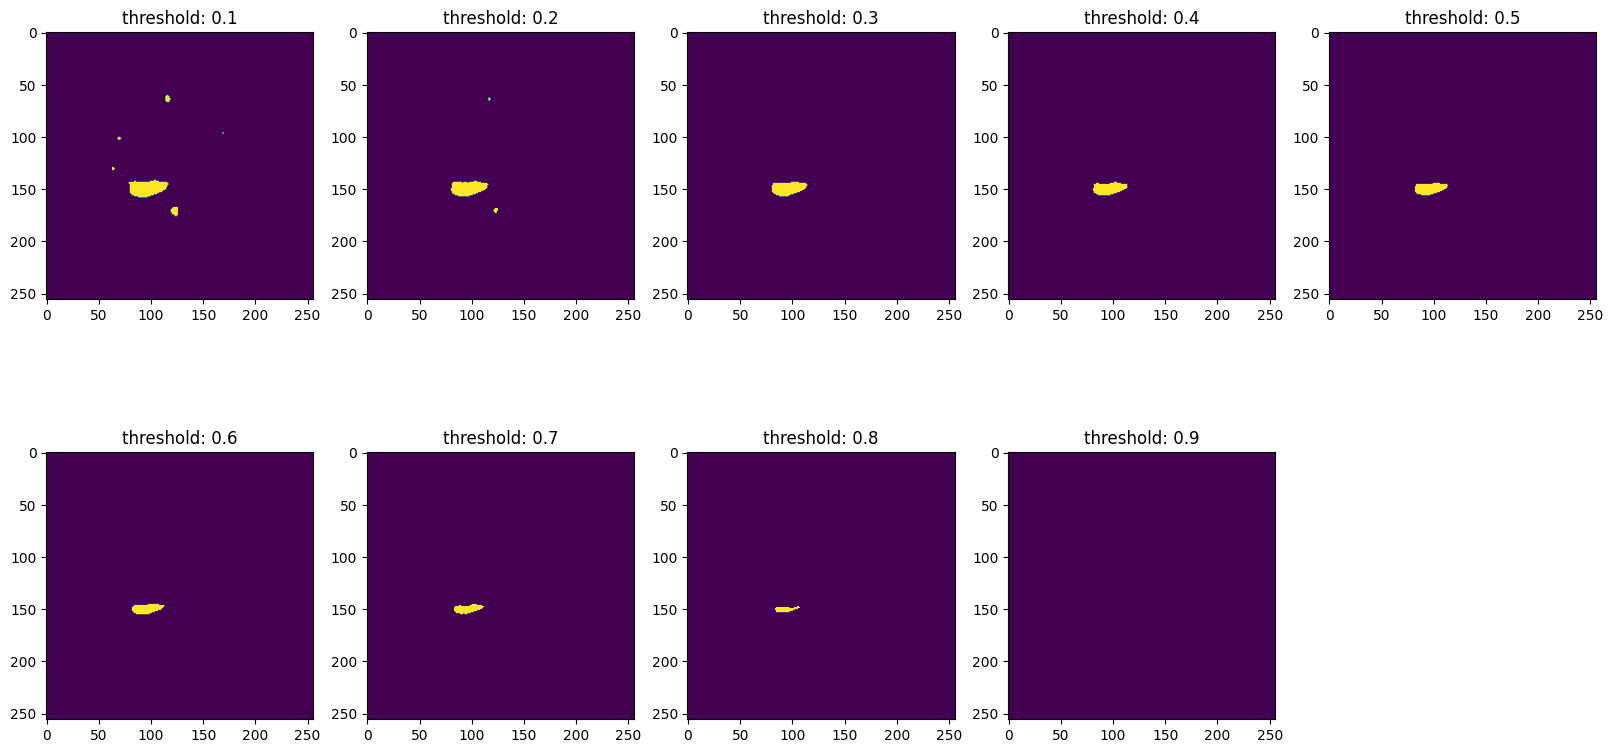

In [ ]:
plt.imshow(mask[img_idx, :, :, 0])
plt.title('Ground Truth')
plt.show()

plt.figure(figsize=(20, 10))
for i in range(1, 10):
    plt.subplot(2, 5, i)
    threshold = i * 0.1
    mask_threshold = mask_pred_raw.copy()
    mask_threshold[mask_threshold <= threshold] = 0.
    mask_threshold[mask_threshold > threshold] = 1.
    plt.imshow(mask_threshold)
    plt.title(f'threshold: {threshold:.1f}')
plt.show()